In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import ta, pickle, json, time

# Get data

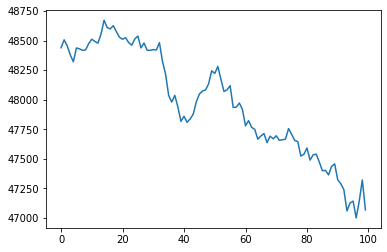

In [59]:
df = pd.read_csv("data/train.csv")
plt.plot(df.open[:100])

In [60]:
df

,timestamp,open,high,low,close,volume
0,2021-05-15 22:02:00,48439.11,48523.38,48435.98,48506.05,19.263924
1,2021-05-15 22:03:00,48506.04,48506.04,48448.00,48454.97,21.732334
2,2021-05-15 22:04:00,48454.97,48456.95,48378.85,48380.19,34.397880
3,2021-05-15 22:05:00,48378.86,48378.86,48310.89,48320.64,28.305630
4,2021-05-15 22:06:00,48320.64,48484.49,48320.63,48437.13,42.514373
...,...,...,...,...,...,...
1435,2021-05-16 21:57:00,45199.99,45207.20,45000.78,45030.13,141.534753
1436,2021-05-16 21:58:00,45030.13,45146.76,45016.15,45092.04,124.272071
1437,2021-05-16 21:59:00,45092.04,45234.66,45090.00,45195.96,81.029058
1438,2021-05-16 22:00:00,45195.29,45321.26,45163.65,45273.19,139.839558


In [61]:
def get_features(df):
    # adding RSI
    df["rsi"] = ta.momentum.rsi(df.close, fillna=True)/100
    # adding StochasticOscillator
    """
    stoch = ta.momentum.StochasticOscillator(high=df.high, low=df.low, close=df.close, 
                                             fillna=True)
    df["stoch"] = stoch.stoch() / 100
    df["stoch_signal"] = (stoch.stoch_signal() - stoch.stoch() + 100) / 200
    """
    
    # adding Bollinger
    bb = ta.volatility.BollingerBands(close=df.close, window=14, window_dev=2, 
                                      fillna=True)
    diff = bb.bollinger_hband() - bb.bollinger_lband()
    df["bb"] = ((df.close - bb.bollinger_mavg()) / 
                 (diff + diff.mean()) + 0.5)
    
    # adding Money Flow Index (MFI)
    df["mfi"] = ta.volume.money_flow_index(
                high=df.high, low=df.low, close=df.close, 
                volume=df.volume, window=14, fillna=True) / 100
    
    # adding Average True Range (ATR)
    atr = ta.volatility.AverageTrueRange(high=df.high, low=df.low, close=df.close, 
                                         window=14, fillna=True)
    df["atr"] = atr. average_true_range()

In [62]:
get_features(df)
df

,timestamp,open,high,low,close,volume,rsi,bb,mfi,atr
0,2021-05-15 22:02:00,48439.11,48523.38,48435.98,48506.05,19.263924,1.000000,0.500000,0.500000,0.000000
1,2021-05-15 22:03:00,48506.04,48506.04,48448.00,48454.97,21.732334,0.000000,0.452998,0.000000,0.000000
2,2021-05-15 22:04:00,48454.97,48456.95,48378.85,48380.19,34.397880,0.000000,0.396784,0.000000,0.000000
3,2021-05-15 22:05:00,48378.86,48378.86,48310.89,48320.64,28.305630,0.000000,0.369045,0.000000,0.000000
4,2021-05-15 22:06:00,48320.64,48484.49,48320.63,48437.13,42.514373,0.420295,0.524884,0.334960,0.000000
...,...,...,...,...,...,...,...,...,...,...
1435,2021-05-16 21:57:00,45199.99,45207.20,45000.78,45030.13,141.534753,0.472726,0.222655,0.297713,193.787326
1436,2021-05-16 21:58:00,45030.13,45146.76,45016.15,45092.04,124.272071,0.497968,0.316962,0.259928,189.274660
1437,2021-05-16 21:59:00,45092.04,45234.66,45090.00,45195.96,81.029058,0.537952,0.436807,0.322288,186.087899
1438,2021-05-16 22:00:00,45195.29,45321.26,45163.65,45273.19,139.839558,0.565640,0.526236,0.403091,184.053763


In [63]:
df.mean()

open      47865.173076
high      47926.436910
low       47806.271396
close     47863.014583
volume       78.180411
rsi           0.483836
bb            0.483076
mfi           0.480524
atr         118.630001
dtype: float64

# GA

## Create Population

In [89]:
# indiv shape (7, 2)
n_indicator = 3 # 7 indicators
n_action = 2
n_borne = 2
def conform_indiv(indiv):
    for indicator in range(n_indicator): # 7 indicators
        for action in range(n_action):
            inf_index = (indicator, action, 0)
            sup_index = (indicator, action, 1)
            if indiv[inf_index] > indiv[sup_index]:
                indiv[inf_index], indiv[sup_index] = indiv[sup_index], indiv[inf_index]
    return indiv

def crossover(indiv1, indiv2, rate=.5):
    indiv1 = indiv1.reshape((((n_indicator+1)*n_action*n_borne)))
    indiv2 = indiv2.reshape((((n_indicator+1)*n_action*n_borne)))
    indiv = []
    for i in range((n_indicator+1)*n_action*n_borne):
        if np.random.random() > rate:
            indiv.append(indiv1[i])
        else:
            indiv.append(indiv2[i])
    indiv = np.array(indiv).reshape((n_indicator+1, n_action, n_borne))
    return indiv

def create_indiv():
    indiv = np.random.random((n_indicator+1, n_action, n_borne))
    indiv = conform_indiv(indiv)
    return indiv

def perfect_analysis(rate=0):
    indiv1 = np.array([
        [[0.01, 0.3], # RSI BUY
        [0.7, 0.09]], # RSI SELL
        
#        [[0.01, 0.3], # Stoch BUY
#        [0.7, 0.09]], # Stoch SELL

#        [[0.5, 0.75], # Stoch_signal - Stoch BUY
#        [0.25, 0.5]], # Stoch_signal - Stoch SELL


        [[0.01, 0.3], # BB BUY
        [0.7, 0.09]], # BB SELL

        [[0.01, 0.3], # MFI BUY
        [0.7, 0.09]], # MFI SELL

        [[0.5, 0.3], # ATR BUY (TP = 5*ATR + price, SL = 5*ATR - price)
        [0.5, 0.3]], # ATR SELL (TP = 5*ATR - price, SL = 5*ATR + price)
    ])
    return crossover(indiv1, create_indiv(), rate=rate)

In [90]:
def create_pop(size=100):
    pop = [(None, perfect_analysis(0.5), 0) for i in range(size)]
    return pop

##  Evaluation

In [75]:
spread = 30
indicators = ['rsi', 'stoch', 'stoch_signal', 'aroon', 'aroon_down', 'aroon_up', 'atr']
indicators = ['rsi', 'bb', 'mfi']

def match_condition(indiv, df):
    for i in range(n_indicator):
        inf = indiv[i, 0]
        sup = indiv[i, 1]
        value = df[indicators[i]]
        if value < inf or value > sup:
            return False
    return True

def trade(df, low, high, start):
    ls = df.values.tolist()
    n = len(ls)
    for i in range(n):
        if ls[i][0] > high: # test high
            return high, i
        if ls[i][1] < low: # test low
            return low, i
    return start, n

def eval_indiv(indiv, df):
    n = len(df)
    score = 0
    i = 15
    while i < n-15:
        df_indicators = df.iloc[i][indicators]
        price = df.iloc[i]["close"]
        atr = df.iloc[i]["atr"]
        if match_condition(indiv[:, 0], df_indicators): # Test achat
            out, d = trade(df.iloc[i:][["high", "low"]], 
                            price + (indiv[-1, 0, 0]*5*atr),
                            price - (indiv[-1, 0, 1]*5*atr),
                            price
                           )
            score += (out-price) - spread
            i += d
        if match_condition(indiv[:, 1], df_indicators): # Test vente
            out, d = trade(df.iloc[i:][["high", "low"]], 
                            price - (indiv[-1, 1, 0]*5*atr),
                            price + (indiv[-1, 1, 1]*5*atr),
                            price
                           )
            score += (price-out) - spread
            i += d
        i+=1
    return score

In [95]:
perfect_analysis(0)

array([[[0.01, 0.3 ],
        [0.7 , 0.09]],

       [[0.01, 0.3 ],
        [0.7 , 0.09]],

       [[0.01, 0.3 ],
        [0.7 , 0.09]],

       [[0.5 , 0.3 ],
        [0.5 , 0.3 ]]])

In [101]:
eval_indiv(perfect_analysis(0.5), df)

0

# Selection

In [76]:
def create_cross_pop(ls, size):
    ls_ = []
    n = len(ls)
    for i in range(size):
        a, b = np.random.randint(n, size=2)
        ls_.append((None, crossover(ls[a][1], ls[b][1]), 0))
    return ls_
    
def mutation(ls, rate=.3):
    for i in range(len(ls)):
        indiv = ls[i][1]
        indiv_ = create_indiv()
        indiv = crossover(indiv, indiv_, rate)
        ls[i] = (None, indiv, 0)
    return ls

def new_gen(ls):
    ls_ = []
    best_times = 0
    for (score, indiv, times) in ls[:10]: # taille 10
        if score > 0:
            times += 1
        best_times = max(best_times, times)
        ls_.append((score, indiv, times+1))
    ls_ = ls_ + mutation(ls_) # taille 10+10 = 20
    ls_ = ls_ + create_cross_pop(ls[:30], 50) # taille 20+50 = 70
    ls_ = ls_ + create_pop(30) # taille 70+30 = 100
    return ls_, best_times

# Processus

In [77]:
list_df = []
delta = 2120
for i in range(40):
    list_df.append(df.iloc[80+i*delta:80+(i+1)*delta:])
len(list_df)

40

In [78]:
def unarray(array):
    result = []
    for i in range(len(array)):
        values = array[i]
        result.append((values[0], values[1].tolist(), values[2]))
    return result

In [92]:
best_score = -1
best_times = 0
gen = 1
population = create_pop()
liste_best = []

while best_times < 40:
    df_ = list_df[gen%40]
    for i in range(len(population)):
        population[i] = (eval_indiv(population[i][1], df_), population[i][1], population[i][2])
    population.sort(key=lambda x: x[0], reverse=True)
    best_score = population[0][0]
    lowest_score = population[-1][0]
    liste_best.append(best_score)
    
    temp = unarray(population)
    json.dump(temp[0], open(f"record/{gen}.json", "w"))
    json.dump(temp, open(f"record/actual.json", "w"))
    population, best_times = new_gen(population)
    print(f"Generation {gen} best_score : {best_score}")
    print(f"Times : {best_times}")
    print(f"lowest_score : {lowest_score}")
    gen += 1
    time.sleep(5)

Generation 1 best_score : 0
Times : 0
lowest_score : 0
Generation 2 best_score : 0
Times : 0
lowest_score : 0
Generation 3 best_score : 0
Times : 0
lowest_score : 0
Generation 4 best_score : 0
Times : 0
lowest_score : 0
Generation 5 best_score : 0
Times : 0
lowest_score : 0


KeyboardInterrupt: 

In [66]:
temp = unarray(population)
json.dump(temp[0], open(f"record/{gen}.json", "w"))
json.dump(temp, open(f"record/actual.json", "w"))

In [62]:
temp

[[0,
  array([[[0.42947249, 0.87222359],
          [0.00852445, 0.58057268]],
  
         [[0.40215551, 0.47525154],
          [0.42048782, 0.87676034]],
  
         [[0.62680327, 0.70567457],
          [0.07928321, 0.74364249]],
  
         [[0.7635654 , 0.9454976 ],
          [0.15906039, 0.19744593]],
  
         [[0.24314256, 0.74768589],
          [0.44298847, 0.98698   ]],
  
         [[0.61208243, 0.62540287],
          [0.43479358, 0.93902795]],
  
         [[0.4516605 , 0.97322841],
          [0.28495242, 0.83164267]]]),
  0],
 [0,
  array([[[0.67421216, 0.94990979],
          [0.65608199, 0.9701641 ]],
  
         [[0.51978883, 0.99474515],
          [0.32411734, 0.8260382 ]],
  
         [[0.56919073, 0.7817617 ],
          [0.06246408, 0.29015523]],
  
         [[0.4259078 , 0.47728685],
          [0.22728492, 0.37836679]],
  
         [[0.02118308, 0.48542675],
          [0.21877809, 0.61469389]],
  
         [[0.09715056, 0.66073255],
          [0.44061724, 0.56261012]],


# Testing result

In [21]:
population

[(None,
  array([[[0.06332101, 0.31679554],
          [0.43225743, 0.799737  ]],
  
         [[0.37645825, 0.77380917],
          [0.51424074, 0.95560542]],
  
         [[0.86371351, 0.97110912],
          [0.54066928, 0.80679498]],
  
         [[0.19311894, 0.26892905],
          [0.23783564, 0.39793843]],
  
         [[0.13053637, 0.65249854],
          [0.20760058, 0.47130995]],
  
         [[0.16493456, 0.92553371],
          [0.63830879, 0.76348641]],
  
         [[0.37088747, 0.96253349],
          [0.33185917, 0.91444379]]])),
 (None,
  array([[[0.27115222, 0.42958057],
          [0.54857296, 0.8504211 ]],
  
         [[0.00769851, 0.68297616],
          [0.13146086, 0.46383991]],
  
         [[0.79036061, 0.99519789],
          [0.30002364, 0.74029509]],
  
         [[0.05268712, 0.42807813],
          [0.04751869, 0.41931972]],
  
         [[0.24753915, 0.37807649],
          [0.47746342, 0.48232637]],
  
         [[0.35979219, 0.54827751],
          [0.12846606, 0.32572002]],

In [22]:
with open(f"record/actual", "rb") as fp:   #Pickling
    population = pickle.load(fp)
population

[(6733.575940218907,
  array([[[0.02914264, 0.73032576],
          [0.1160545 , 0.51305172]],
  
         [[0.37645825, 0.77380917],
          [0.51424074, 0.95560542]],
  
         [[0.86371351, 0.97110912],
          [0.71802007, 0.86029045]],
  
         [[0.4410307 , 0.48461594],
          [0.23783564, 0.39793843]],
  
         [[0.13053637, 0.65249854],
          [0.20760058, 0.47130995]],
  
         [[0.16493456, 0.92553371],
          [0.00131751, 0.39252566]],
  
         [[0.14901292, 0.95109901],
          [0.33185917, 0.91444379]]])),
 (5924.485530752594,
  array([[[0.27115222, 0.42958057],
          [0.15865859, 0.47277849]],
  
         [[0.00769851, 0.68297616],
          [0.47547668, 0.93030657]],
  
         [[0.28030837, 0.35709158],
          [0.30002364, 0.74029509]],
  
         [[0.35590118, 0.89990594],
          [0.04751869, 0.41931972]],
  
         [[0.24753915, 0.37807649],
          [0.47746342, 0.48232637]],
  
         [[0.81010846, 0.85212204],
          

In [23]:
indiv = population[0][1]

In [26]:
def trade(df, low, high, start):
    ls = df.values.tolist()
    for i in range(len(ls)):
        if ls[i][0] > high: # test high
            print(i)
            return high
        if ls[i][1] < low: # test low
            print(i)
            return low
    return start


def eval_indiv_test(indiv, df):
    n = len(df)
    score = 0
    ordre = [[], []]
    for i in range(15, n-15):
        df_indicators = df.iloc[i][indicators]
        if match_condition(indiv[:, 0], df_indicators): # Test achat
            print("ACHAT")
            price = df.iloc[i]["close"]
            ordre[0].append(i)
            ordre[1].append(price)
            out = trade(df.iloc[i:][["high", "low"]], 
                        price * (indiv[-1, 0, 0]+.5),
                        price * (indiv[-1, 0, 1]+.5),
                        price
                       )
            score += (out-price) - spread
        
        if match_condition(indiv[:, 1], df_indicators): # Test vente
            print("VENTE")
            price = df.iloc[i]["close"]
            ordre[0].append(i)
            ordre[1].append(price)
            out = trade(df.iloc[i:][["high", "low"]], 
                        price * (indiv[-1, 1, 0]+.5),
                        price * (indiv[-1, 1, 1]+.5),
                        price
                       )
            score += (price-out) - spread
    return score, ordre
scores, orders = [], []
for i in range(40):
    print(i)
    score, ordre = eval_indiv_test(indiv, list_df[i])
    scores.append(score)
    orders.append(ordre)

0
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
1
VENTE
VENTE
2
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
3
VENTE
VENTE
VENTE
VENTE
VENTE
4
VENTE
VENTE
5
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
6
VENTE
1876
VENTE
1874
VENTE
1517
VENTE
1515
VENTE
1183
VENTE
1008
VENTE
7
VENTE
VENTE
8
VENTE
VENTE
9
VENTE
VENTE
10
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
11
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
12
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
13
VENTE
VENTE
VENTE
VENTE
VENTE
14
VENTE
VENTE
VENTE
15
VENTE
VENTE
16
ACHAT
VENTE
17
VENTE
VENTE
VENTE
VENTE
VENTE
18
VENTE
VENTE
VENTE
19
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
20
VENTE
VENTE
VENTE
VENTE
21
VENTE
VENTE
22
VENTE
VENTE
VENTE
23
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
24
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
25
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VENTE
VE

In [28]:
indiv

array([[[0.02914264, 0.73032576],
        [0.1160545 , 0.51305172]],

       [[0.37645825, 0.77380917],
        [0.51424074, 0.95560542]],

       [[0.86371351, 0.97110912],
        [0.71802007, 0.86029045]],

       [[0.4410307 , 0.48461594],
        [0.23783564, 0.39793843]],

       [[0.13053637, 0.65249854],
        [0.20760058, 0.47130995]],

       [[0.16493456, 0.92553371],
        [0.00131751, 0.39252566]],

       [[0.14901292, 0.95109901],
        [0.33185917, 0.91444379]]])

In [27]:
scores

[-240.0,
 -60.0,
 -240.0,
 -150.0,
 -60.0,
 -330.0,
 40797.072210767736,
 -60.0,
 -60.0,
 -60.0,
 -360.0,
 -240.0,
 -240.0,
 -150.0,
 -90.0,
 -60.0,
 -60.0,
 -150.0,
 -90.0,
 -270.0,
 -120.0,
 -60.0,
 -90.0,
 -360.0,
 -300.0,
 -450.0,
 -180.0,
 -150.0,
 -270.0,
 -60.0,
 -480.0,
 -480.0,
 -150.0,
 -120.0,
 -270.0,
 86728.76967440473,
 -60.0,
 -120.0,
 -240.0,
 -360.0]

In [308]:
len(ordre[0])

118

In [310]:
indiv

array([[[5.37439555e-03, 7.67343265e-01],
        [1.98508601e-02, 6.37935004e-01]],

       [[3.22765232e-02, 9.95086903e-01],
        [3.57818550e-01, 6.60599174e-01]],

       [[7.98987501e-04, 8.30657881e-01],
        [3.35623964e-01, 6.79689057e-01]],

       [[1.55014361e-01, 9.79410228e-01],
        [1.75791397e-02, 2.29564062e-01]],

       [[1.25399350e-02, 7.32196314e-01],
        [6.40864664e-01, 9.61259592e-01]],

       [[5.07000530e-02, 9.68362793e-01],
        [8.90148648e-03, 2.60082838e-01]],

       [[9.05290077e-01, 9.41884512e-01],
        [1.56291855e-01, 2.25117920e-01]]])